# 05 Logistic regression baseline   
---

# CHECKUP LIST
- [x] Logreg performance
- [x] CVed grid search
- [x] Class probability per image
- [x] Relationship between regularization strength and class probability

# TASK 1. Evaluate the logistic regression baseline  
In my work I evaluated several hundred models, constructed with different C values and with or without scaling, 
Overall, the logistig regression models contructed using raw extracted features form images (no scaling) perfomed better then the models constructed with feature scaling. Several models different C values (from ~0 to 1291) allowed achieved validation accuracy over 93%. The best performing model allowed classyfing images in validation datsets with 93.8% accuracy, and it was used to display the probabilities in task 3 on predictions made with test data.

# TASK 2. Tune its regularization strength parameter with cross-validated grid-search
DONE, Please see function for grid search with cross validation, below. 
For more details in the function, please see my_logredCV() in src.utils.logreg_tools or simply type help(my_logredCV). The results were briefly described in the above in task 1. 

# TASK 3. Pick ten images and compute the probability for each class using the predict_proba() function of your estimator. Plot the results for each image and comment your findings. For example, you can plot the ten images in subplots and collect the probabilities in a DataFrame.
The predictions includiong probability calculation has been done automatically by the function that I created for each model. The results can be found in the last cell. overall, it is important to notice that several images that were incorrectly classified, such as imgae of the truck classified as class other, had lower probability then the correctly classified images using the best performing model, created with logreg approach. 


# Config

In [20]:
# ************************************************************************* #
#     Author:   Pawel Rosikiewicz                                           #       
#     Copyrith: IT IS NOT ALLOWED TO COPY OR TO DISTRIBUTE                  #
#               these file without written                                  #
#               persmission of the Author                                   #
#     Contact:  prosikiewicz@gmail.com                                      #
#                                                                           #
# ************************************************************************* #

# Config

# basedir
basedir = '/Users/pawel/Desktop/Activities/005__COURSES/000__EPFLext_ADSML/Module 4 __ Project/solution'

# project config
project_name = "Pawel_Rosikiewicz_EPFLext_Project4"
dataset_name = "swissroads"
subset_names = ["train", "valid", "test"]
module_names = ["imagenet"]
class_colors = {          "car": "orange",
                          "van": "steelblue",
                          "truck": "red",
                          "bike": "forestgreen",
                          "motorcycle" : "purple",
                           "other": "dimgrey"}

# task config
task_name = "logreg"
train_subset_names = ["train", "valid"] # data subsets, used together in part 1 and in part 3 for ploting image examples and PCA analyis
test_subset_names = ["test"]

# Note:
"""in some cases train, test and valid datasets, may be also subset names of the datasets, 
   this script works by loading selected daset subsets into either train and test category, 
   validation ataset is created automatically, at random fro 30% of train dataset.
   all saved predictions have reference to original images in raw data
""";

# Load packages

In [21]:
import os # allow changing, and navigating files and folders, 
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import random # functions that use and generate random numbers

import cv2
import pickle
import warnings
import numpy as np # support for multi-dimensional arrays and matrices
import pandas as pd # library for data manipulation and analysis
import seaborn as sns # advance plots, for statistics, 
import matplotlib as mpl # to get some basif functions, heping with plot mnaking 
import tensorflow_hub as hub
import tensorflow as tf # tf.__version__ 
import tensorflow.keras as keras 
import matplotlib.pyplot as plt # for making plots, 
import scipy.stats as stats  # library for statistics and technical programming, 
import scipy.cluster.hierarchy as sch

from PIL import Image, ImageDraw
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale

# Load custom functions created for the project from basedir/src/utils

In [22]:
os.chdir(basedir)
sys.path.append(basedir)

# my tools, loaded only form basedir, 
from src.utils.data_loaders import load_encoded_imgbatch_using_logfile, load_raw_img_batch
from src.utils.example_plots_after_clustering import plot_img_examples, create_spaces_between_img_clusters, plot_img_examples_from_dendrogram
from src.utils.annotated_pie_charts import annotated_pie_chart_with_class_and_group, prepare_img_classname_and_groupname
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.logreg_tools import my_logredCV, plot_examples_with_predictions_and_proba,plot_examples_with_predictions_and_proba_gamma 
from src.utils.random_forest import random_forest_grid_search, plot_random_tree_summary_andor_table
from src.utils.SVM_tools import SVM_grid_search, plot_grid_acc_and_return_summary_df
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.model_summary_plots import plot_grid_acc_and_return_summary_df, visual_model_summary, model_gridsearch_summary_plots

# one of my functions was generating warnign, on copies, despite using proper syntax, 
warnings.filterwarnings("ignore")

# setup paths for the task

In [25]:
PATH_raw = os.path.join(basedir, "data/raw", dataset_name)
PATH_encoded = os.path.join(basedir, "data/interim", dataset_name)
PATH_results = os.path.join(basedir, "data/results", f"{dataset_name}_{task_name}")

# create new direcory for task results, 
try: 
    os.mkdir(PATH_results)
    try:
        os.chdir(PATH_results)
        print("PATH_results was created")
    except:
        print("ERROR: PATH_results was not created correctly")
except: 
    print("file already exist, or PATH_results was not created correctly")

file already exist


# CVed grid search
* here the results for all tasks are created with one function

In [7]:
# ...........................................................................................
# grid search with cross-validation on parameters provided for logarithmic regression, 
""" the main function was saved in .py file in src/utils
    it will donwload proper files automatically, mix train and valid data, 
    provide them to the crossvalidation function, and perfomr scaling if required, before cross validations.
    Additionally, the fucntion performs predictions on datasets used for model evaluateion a
    and the results can be presented with probabilities required in TASK 3.
"""
for module_name in module_names:
    print(f"- {module_name} -")
    
    # STEP 1. run CVgrid search,     
    summary_table, model_predictions_dict = my_logredCV(
        path =PATH_encoded,
        dataset_name = dataset_name,
        subset_names_tr =train_subset_names,
        subset_names_te =test_subset_names,
        module_names = [module_name],
        class_encoding =dict(zip(list(class_colors.keys()), list(range(len(class_colors))))),
        pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('logreg', LogisticRegression(
                    multi_class='ovr', 
                    solver='liblinear'
                ))
            ]),
        grid_kwargs = {
                'scaler': [None, StandardScaler()],
                'logreg__C': np.logspace(-4, 4, num=10) 
            },
        method_name = task_name,
        cv_nr = 5,                     
        store_predictions =True, 
        verbose =True
    )

        
    # step 3. save files
    os.chdir(PATH_results)

    # .. save summary table
    pd.DataFrame(summary_table).to_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv", header=True)

    # .. save the model_predictions_dict into a pickle file
    with open(f"{task_name}__{module_name}__{dataset_name}__model_predictions_dict.p", 'wb') as file: # wb - write binary,
        pickle.dump(model_predictions_dict, file)     
    
    
print("\nDONE....")

- imagenet -
................................................................................
0: imagenet, logfie: imagenet_swissroads_logfile.csv
 --- Number of tested combinations 20

DONE....


# Evaluate Logreg performance

### Show top ten best performing models
* classyfication is based on validation accuracy, 
* NaN in table below denotes default values, such as no scaling, 

In [9]:
# SHOW TABLE WITH 10 BEST PERFORMINGH MODELS, 
for i, module_name in enumerate(module_names):
    try:
        # reload the data
        os.chdir(PATH_results)
        one_module_summary_df = pd.read_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv")
        
        if i==0:
            summary_df = one_module_summary_df   
        else:
            summary_df = pd.concat([summary_df,one_module_summary_df], axis=0)
    except:
        pass
    
# show best models created with each module,
features_to_display = ["module", "model_acc_valid", "model_acc_train",
                       "baseline_acc_train", "param_logreg__C", "param_scaler"]
df_sorted = summary_df.sort_values("model_acc_valid", ascending=False).loc[:,features_to_display].head(10)
display(df_sorted.head(10))

module  model_acc_valid  model_acc_train  baseline_acc_train  \
17  imagenet         0.937947          1.00000            0.236277   
11  imagenet         0.935561          1.00000            0.236277   
3   imagenet         0.935561          0.97555            0.236277   
9   imagenet         0.935561          1.00000            0.236277   
13  imagenet         0.933174          1.00000            0.236277   
7   imagenet         0.933174          1.00000            0.236277   
8   imagenet         0.933174          1.00000            0.236277   
10  imagenet         0.930788          1.00000            0.236277   
15  imagenet         0.930788          1.00000            0.236277   
12  imagenet         0.930788          1.00000            0.236277   

    param_logreg__C                                       param_scaler  
17      1291.549665  StandardScaler(copy=True, with_mean=True, with...  
11         2.782559  StandardScaler(copy=True, with_mean=True, with...  
3          0.000774  StandardScaler(copy=True, with_mean=True, with...  
9          0.359381  StandardScaler(copy=True, with_mean=True, with...  
13        21.544347  StandardScaler(copy=True, with_mean=True, with...  
7          0.046416  StandardScaler(copy=True, with_mean=True, with...  
8          0.359381                                                NaN  
10         2.782559                                                NaN  
15       166.810054  StandardScaler(copy=True, with_mean=True, with...  
12        21.544347                                                NaN

## Explore The Relationship between regularization strength and class probability

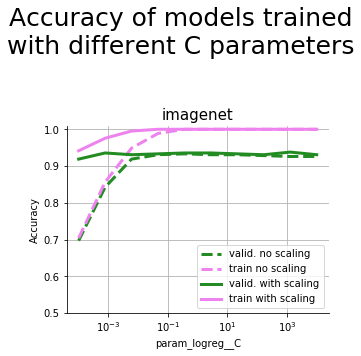

In [16]:
# work on copy
results_df = summary_df.copy()

# data preparation, 
plot_title = "Accuracy of models trained\nwith different C parameters"
x_limits = (0,20)
leg_loc = "lower right"

valid_color = "forestgreen"
train_color = "violet"


# Evaluate Accuracy of knn classifers created using features extracted from images with four different tfhum modules, 
fig, axs = plt.subplots(nrows=1, ncols=len(module_names), figsize=(4.5*len(module_names),5), facecolor="white")
fig.suptitle(plot_title, fontsize=25)
if len(module_names)>1: axss = axs.flat
else: axss = [axs]

# ...
for i, (module_name, ax) in enumerate(zip(module_names, axss)):
    
    df = results_df.loc[results_df.module==module_name,:]
    #df = results_df
    
    # first plot logreg without scaling
    linestyle="--"
    linewidth = 3
    sel = df.param_scaler.isnull()
    x =df.param_logreg__C.loc[sel]
    ax.semilogx(x, df.model_acc_valid.loc[sel], ls=linestyle, lw=linewidth, color=valid_color, 
                label="valid. no scaling")
    ax.semilogx(x, df.model_acc_train.loc[sel], ls=linestyle, lw=linewidth, color=train_color,
               label="train no scaling")
    
    # first plot logreg without scaling
    linestyle="-"
    linewidth = 3
    sel = df.param_scaler.isnull()==False
    x =df.param_logreg__C.loc[sel]
    ax.semilogx(x, df.model_acc_valid.loc[sel], ls=linestyle, lw=linewidth, color=valid_color,
                               label="valid. with scaling")
    ax.semilogx(x, df.model_acc_train.loc[sel], ls=linestyle, lw=linewidth, color=train_color,
                               label="train with scaling")
    
    # aestetics, 
    ax.set_title(module_name, fontsize=15)
    ax.set_xlabel('param_logreg__C')
    ax.set_ylabel('Accuracy')
    ax.set(ylim=y_limits)
    ax.legend(loc="lower right")
    ax.grid()
    sns.despine()
    #ax.legend(loc=leg_loc)
    
fig.tight_layout()
fig.subplots_adjust(top=0.65)
plt.show()

# Pick ten images and compute the probability for each class using the predict_proba() function of your estimator.
*  I decided to write a function that can display all images classified with the best perfomirng logreg model with probability of a given class displayed on each image 
* border colors arround each picture show true class of that image (see legend, for class-color pairs),
* the groups of images (labelled on top of each group), show classyfication made by the model,
* the probability values displayed on each image were calculated using model.predict_proba() function, 
* Predictions in each group were summarized, on pie plots below the main figure, 
* you may double click on the image to make it larger, 

Found 50 images belonging to 6 classes.


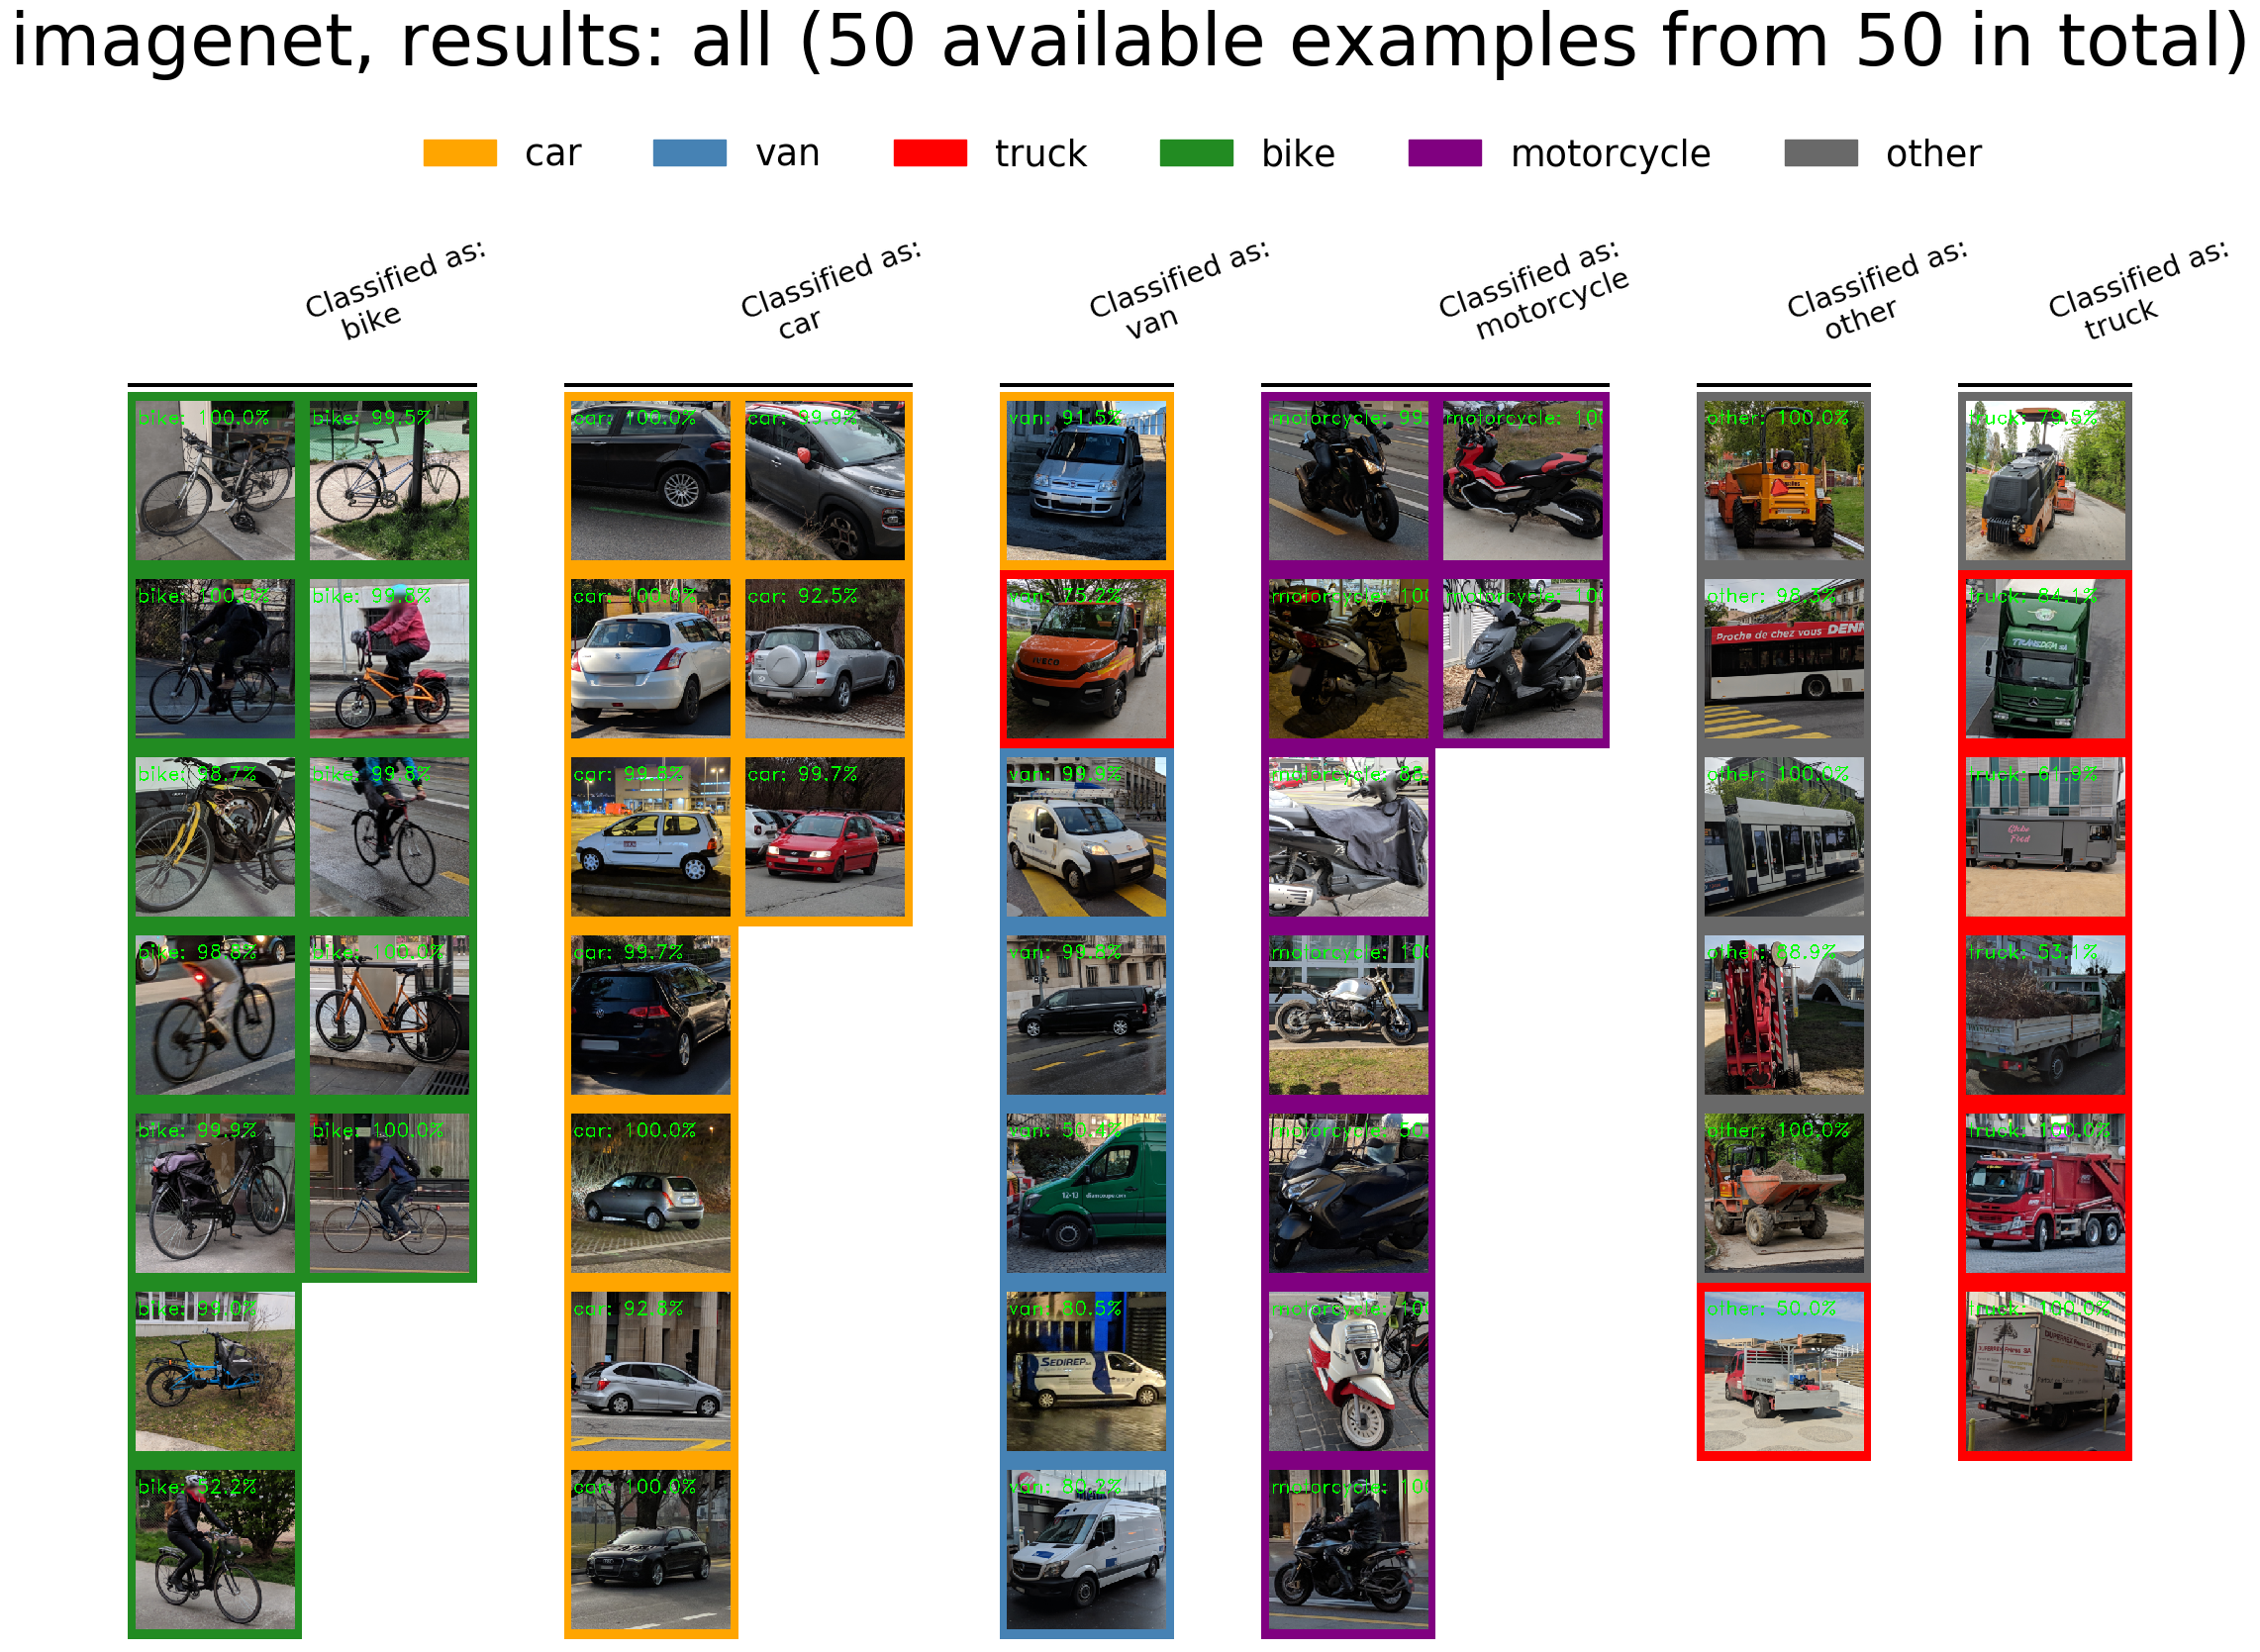

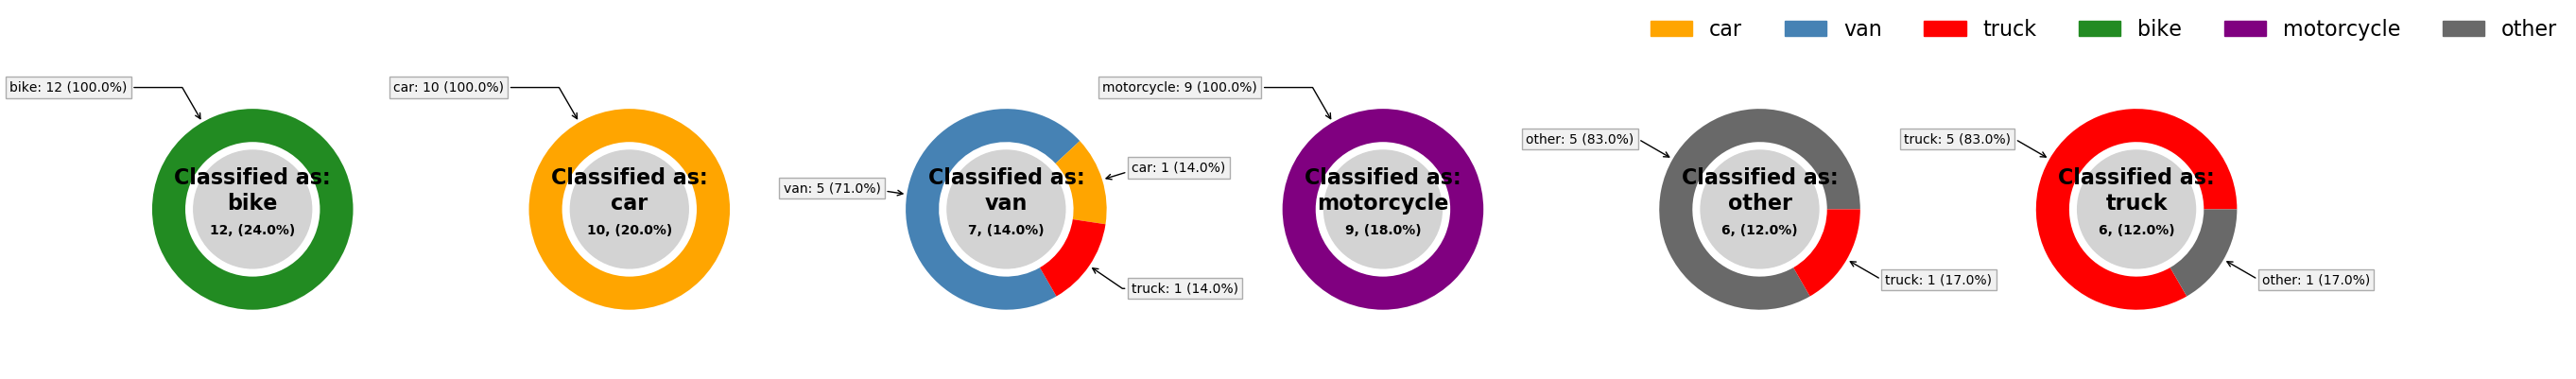

In [26]:
# load model_predictions_dict
os.chdir(PATH_results)
with open(f"{task_name}__{module_names[0]}__{dataset_name}__model_predictions_dict.p", 'rb') as file: # wb - write binary,
    model_predictions_dict  = pickle.load(file) 
          
plot_examples_with_predictions_and_proba_gamma( 
    model_ID=0, # logreg saves predictions only for the best perfoming model as I used CVgridsearch, 
    model_predictions_dict= model_predictions_dict, 
    module_name=module_names[0], 
    dataset_name=dataset_name,                              
    subset_name=["test"], # denotes test predicitons made for test_subset_names
    img_batch_subset_names=test_subset_names, 
    path_to_raw_img_batch=PATH_raw,
    class_colors=class_colors,
    make_plot_with_img_examples=True, # use False, to have only pie charts with classyfication summary                                         
    max_img_per_col=7,
    plot_classyfication_summary=True
)